In [ ]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# 3. Loading Dataset

In [ ]:
!pip install yfinance
!pip install plotly

In [ ]:
import yfinance as yf


In [ ]:
data = yf.download('BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.reset_index(level=0, inplace=True)

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2788,2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489
2789,2022-05-07,36042.503906,36129.925781,34940.824219,35501.953125,35501.953125,24375896406
2790,2022-05-08,35502.941406,35502.941406,33878.964844,34059.265625,34059.265625,36763041910
2791,2022-05-09,34060.015625,34222.074219,30296.953125,30296.953125,30296.953125,63355494961
2792,2022-05-10,30405.373047,32561.984375,29961.925781,31317.775391,31317.775391,82672173056


In [ ]:
#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Bitcoin live share price evolution',
    yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=6, label="6h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Show
fig.show()

In [ ]:
print('Total number of days present in the dataset: ',data.shape[0])
print('Total number of fields present in the dataset: ',data.shape[1])

Total number of days present in the dataset:  2793
Total number of fields present in the dataset:  7


In [ ]:
data.shape

(2793, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2793 entries, 0 to 2792
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2793 non-null   datetime64[ns]
 1   Open       2793 non-null   float64       
 2   High       2793 non-null   float64       
 3   Low        2793 non-null   float64       
 4   Close      2793 non-null   float64       
 5   Adj Close  2793 non-null   float64       
 6   Volume     2793 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 152.9 KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2793.000000,2793.000000,2793.000000,2793.000000,2793.000000,2.793000e+03
mean,12154.145477,12472.491485,11801.493709,12163.506122,12163.506122,1.511018e+10
std,16624.909065,17056.352161,16127.949944,16623.552543,16623.552543,1.994092e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,613.947998,619.848999,609.929016,614.544006,614.544006,8.330810e+07
50%,6467.253906,6556.379883,6360.470215,6469.798340,6469.798340,5.433756e+09
75%,11095.870117,11420.049805,10818.156250,11094.346680,11094.346680,2.570657e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


# Checking for Null Values

In [ ]:
print('Null Values:', data.isnull().values.sum())

Null Values: 0


In [ ]:
print('NA values:',data.isnull().values.any())

NA values: False


In [ ]:
# Final shape of the dataset after dealing with null values 

data.shape

(2793, 7)

# 4. EDA(Exploratory Data Analysis)

In [ ]:
# Printing the start date and End date of the dataset

sd=data.iloc[0][0]
ed=data.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17 00:00:00
Ending Date 2022-05-10 00:00:00


#### StockPrice Analysis from Start

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [ ]:
monthvise= data.groupby(data['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,12855.131424,12828.374881
February,13793.306351,13869.217293
March,14790.177346,14833.352724
April,15132.974493,15119.381881
May,11796.665765,11692.267303
June,9299.305977,9294.420703
July,9285.402500,9330.128271
August,11312.971706,11345.157739
September,10489.365578,10462.378150


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

Note that we only have few months in 2014 so the rest of the months are not plotted since we do not have the data

In [ ]:
data.groupby(data['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = data.groupby(data['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = data.groupby(data['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(data, x=data.Date, y=[data['Open'], data['Close'], data['High'], data['Low']],labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
# Lets First Take all the Close Price 
closedf = data[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2793, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2014-2022', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Now we will Take data of just 1 Year

In [ ]:
closedf = closedf[closedf['Date'] > '2017-01-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  1955


In [ ]:
closedf

,Date,Close
838,2017-01-02,1021.750000
839,2017-01-03,1043.839966
840,2017-01-04,1154.729980
841,2017-01-05,1013.380005
842,2017-01-06,902.200989
...,...,...
2788,2022-05-06,36040.921875
2789,2022-05-07,35501.953125
2790,2022-05-08,34059.265625
2791,2022-05-09,30296.953125


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1955, 1)


* ### Slicing data into Training set and Testing set

In [ ]:
# we keep the training set as 60% and 40% testing set
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1173, 1)
test_data:  (782, 1)


In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1157, 15)
y_train:  (1157,)
X_test:  (766, 15)
y_test (766,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1157, 15, 1)
X_test:  (766, 15, 1)


* # Actuall Model Building

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 15, 512)           1052672   
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [ ]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [ ]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

Epoch 1/50
4/4 [==============================] - 9s 2s/step - loss: 0.0178 - val_loss: 0.0123 - lr: 2.0000e-04
Epoch 2/50
4/4 [==============================] - 6s 1s/step - loss: 0.0162 - val_loss: 0.0132 - lr: 2.0000e-04
Epoch 3/50
4/4 [==============================] - 6s 1s/step - loss: 0.0133 - val_loss: 0.0141 - lr: 2.0000e-04
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0094 - lr: 2.0000e-04
Epoch 5/50
4/4 [==============================] - 6s 1s/step - loss: 0.0069 - val_loss: 0.0110 - lr: 2.0000e-04
Epoch 6/50
4/4 [==============================] - 6s 1s/step - loss: 0.0097 - val_loss: 0.0130 - lr: 2.0000e-04
Epoch 7/50
4/4 [==============================] - 6s 1s/step - loss: 0.0080 - val_loss: 0.0079 - lr: 2.0000e-04
Epoch 8/50
4/4 [==============================] - 6s 1s/step - loss: 0.0068 - val_loss: 0.0080 - lr: 2.0000e-04
Epoch 9/50
4/4 [==============================] - 6s 1s/step - loss: 0.0074 - val_loss: 0.0082 - lr: 2.0

- ### Plotting Loss vs Validation loss 

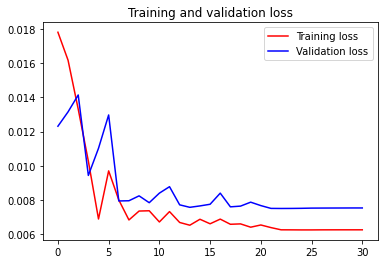

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((1157, 1), (766, 1))

- # Model Evaluation

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

- ## Evaluation metrices RMSE, MSE and MAE

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  735.3756480694973
Train data MSE:  540777.3437736331
Train data MAE:  439.1235001810481
-------------------------------------------------------------------------------------
Test data RMSE:  3375.1329956354775
Test data MSE:  11391522.738227312
Test data MAE:  2333.7545092709693


- ## Variance Regression Score

In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9543493790325223
Test data explained variance regression score: 0.9736121758967893


- ## R square score for regression

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9542069904656909
Test data R2 score: 0.964247566461778


- # Comparision of original stock close price and predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1955, 1)
Test predicted data:  (1955, 1)


- # Predicting next 30 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


- # Plotting last 15 days of dataset and next predicted 30 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({'last_original_days_value':last_original_days_value, 'next_predicted_days_value':next_predicted_days_value})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']], labels={'value': 'Stock price','index': 'Timestamp'},
              color_discrete_map={
                 "Raw": "goldenrod",
                 "Average": "blue"
                 
             })


fig.update_layout(title_text='Compare last 15 days vs next 30 days',plot_bgcolor='black', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



- # Plotting entire Closing Stock Price with next 30 days period of prediction

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
if(original_ytest.all()>test_predict.all()):
  print('buy bitcoin/ profitable to invest')
else:
  print('sell bitcoin/ Not Profitable at the moment')

sell bitcoin/ Not Profitable at the moment
